# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('/Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx), image_height, image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                    
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train'
val_path = '/Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## MODEL BUILDING
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Conv3D, Conv2D, MaxPooling3D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, LSTM, Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt


## SAMPLE MODEL

In [7]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)#create a list of image numbers you want to use for a particular video
    

#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

2023-02-12 21:04:11.639378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 15, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 15, 100, 100, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 50, 50, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 7, 50, 50, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init_sample' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 16
Epoch 1/5
42/42 [==============================] - ETA: 0s - loss: 2.0383 - categorical_accuracy: 0.1885Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 16

Epoch 1: val_loss improved from inf to 1.66667, saving model to model_init_sample_2023-02-1221_04_11.087627/model-00001-2.03826-0.18854-1.66667-0.17000.h5
42/42 [==============================] - 293s 7s/step - loss: 2.0383 - categorical_accuracy: 0.1885 - val_loss: 1.6667 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/5
42/42 [==============================] - ETA: 0s - loss: 1.6304 - categorical_accuracy: 0.2449
Epoch 2: val_loss improved from 1.66667 to 1.48499, saving model to model_init_sample_2023-02-1221_04_11.087627/model-00002-1.63044-0.24490-1.48499-0.28571.h5
42/42 [==============================] - 122s 3s/step - loss: 1.6304 - ca

In [14]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()


**Training Accuracy:** 28.57%

**Validation Accuracy:** 21.43%

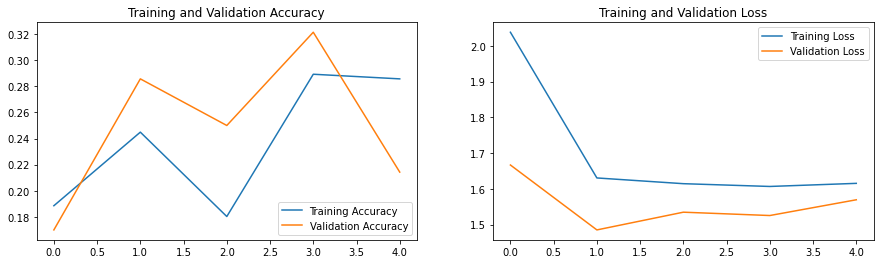

In [15]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)* 100) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)* 100) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)


> From the graph we can see that the model is performing better on the validation data than on the training data. This indicates that the model is too simple and has lesser that required training parameters.

In [16]:
paths = ["/Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train/WIN_20180925_17_26_37_Pro_Thumbs_Up_new/WIN_20180925_17_26_37_Pro_00024.png",
        "/Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train/WIN_20180925_17_37_42_Pro_Stop_new/WIN_20180925_17_37_42_Pro_00068.png"]

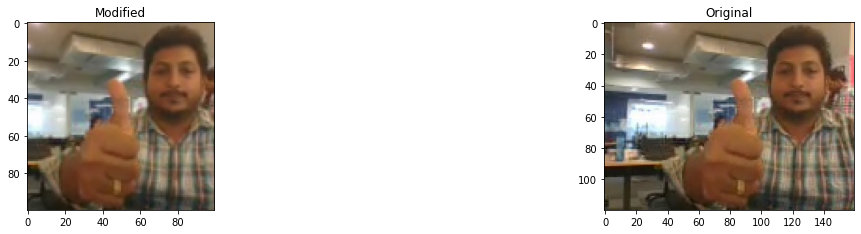

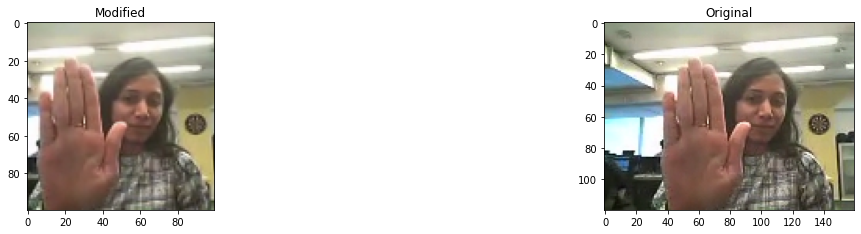

In [17]:
show_resize_crop_image(paths)


## MODEL 1

> Reducing the size of the image from 100 to 50.



In [18]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=10

#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [19]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 50, 50, 16)    1312      
                                                                 
 batch_normalization_3 (Batc  (None, 15, 50, 50, 16)   64        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 15, 50, 50, 16)    0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 25, 25, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 25, 25, 32)     13856     
                                                                 
 batch_normalization_4 (Batc  (None, 7, 25, 25, 32)   

In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'model_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 16
Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 2.0236 - categorical_accuracy: 0.2232Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 16

Epoch 1: val_loss improved from inf to 1.92463, saving model to model_1_2023-02-1221_04_11.087627/model-00001-2.02357-0.22323-1.92463-0.21000.h5
42/42 [==============================] - 120s 3s/step - loss: 2.0236 - categorical_accuracy: 0.2232 - val_loss: 1.9246 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 1.6591 - categorical_accuracy: 0.2891
Epoch 2: val_loss improved from 1.92463 to 1.66542, saving model to model_1_2023-02-1221_04_11.087627/model-00002-1.65905-0.28912-1.66542-0.25000.h5
42/42 [==============================] - 52s 1s/step - loss: 1.6591 - categorical_accuracy:

**Training Accuracy:** 44.440000000000005%

**Validation Accuracy:** 42.86%

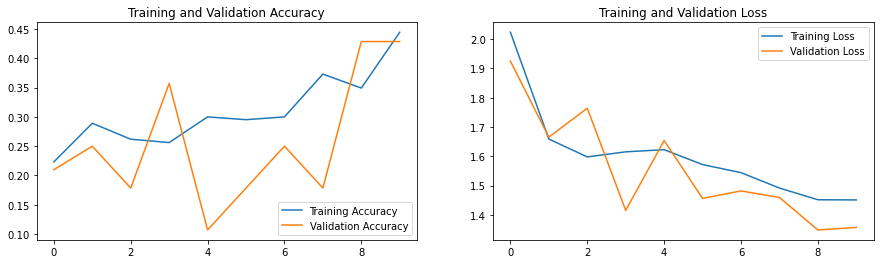

In [24]:
plot_history(history)


**Conclusion**: Scaling to smaller images work better.

## MODEL 2
> Reducing the size of the image from 50 to 25 and raiing the epochs upto 15.

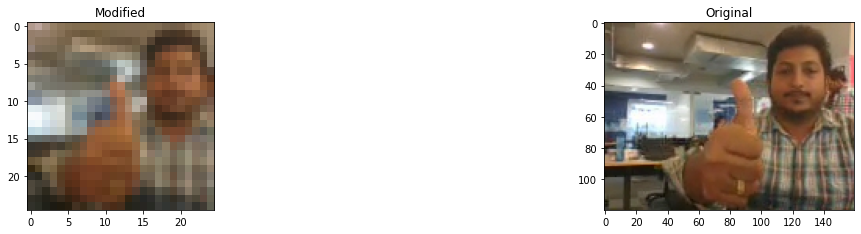

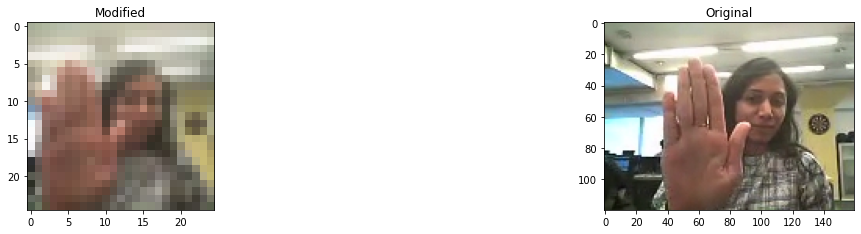

In [25]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=15

show_resize_crop_image(paths)

In [26]:
#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [27]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 25, 25, 16)    1312      
                                                                 
 batch_normalization_6 (Batc  (None, 15, 25, 25, 16)   64        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 15, 25, 25, 16)    0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 12, 12, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 12, 12, 32)     13856     
                                                                 
 batch_normalization_7 (Batc  (None, 7, 12, 12, 32)   

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [29]:
model_name = 'model_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 16
Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 2.1638 - categorical_accuracy: 0.2142Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 16

Epoch 1: val_loss improved from inf to 1.90633, saving model to model_2_2023-02-1221_04_11.087627/model-00001-2.16381-0.21418-1.90633-0.26000.h5
42/42 [==============================] - 103s 2s/step - loss: 2.1638 - categorical_accuracy: 0.2142 - val_loss: 1.9063 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/15
42/42 [==============================] - ETA: 0s - loss: 1.6685 - categorical_accuracy: 0.2517
Epoch 2: val_loss improved from 1.90633 to 1.65531, saving model to model_2_2023-02-1221_04_11.087627/model-00002-1.66853-0.25170-1.65531-0.28571.h5
42/42 [==============================] - 38s 933ms/step - loss: 1.6685 - categorical_accura

**Training Accuracy:** 32.54%

**Validation Accuracy:** 42.86%

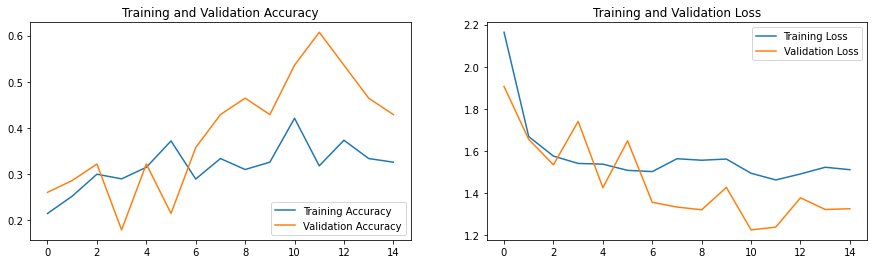

In [32]:
plot_history(history)


> **Conclusion:** Scaling from 50 to 25 reduced the training accuracy, cannot pursue this further.



## MODEL 3
> Decreasing the batch size from 16 to 8 and increasing epochs to 20



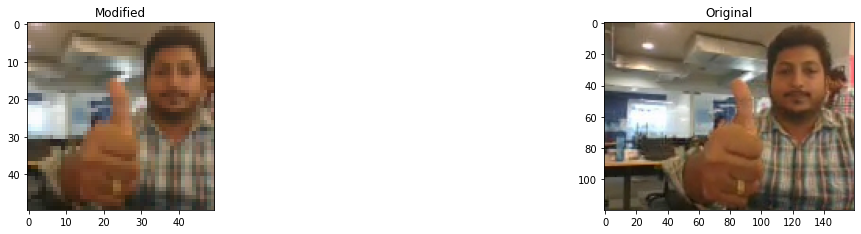

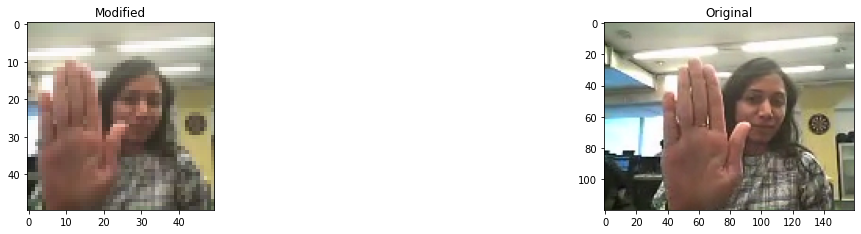

In [33]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 8

num_epochs=20

show_resize_crop_image(paths)

In [34]:
#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

In [35]:
optimiser = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 16)    1312      
                                                                 
 batch_normalization_9 (Batc  (None, 15, 50, 50, 16)   64        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 16)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 25, 25, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 32)     13856     
                                                                 
 batch_normalization_10 (Bat  (None, 7, 25, 25, 32)   

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.9170 - categorical_accuracy: 0.2293Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.93121, saving model to model_32023-02-1221_04_11.087627/model-00001-1.91703-0.22926-1.93121-0.26000.h5
83/83 [==============================] - 133s 2s/step - loss: 1.9170 - categorical_accuracy: 0.2293 - val_loss: 1.9312 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.5420 - categorical_accuracy: 0.3029
Epoch 2: val_loss improved from 1.93121 to 1.50729, saving model to model_32023-02-1221_04_11.087627/model-00002-1.54198-0.30293-1.50729-0.23077.h5
83/83 [==============================] - 108s 1s/step - loss: 1.5420 - categorical_accuracy: 0.

**Training Accuracy:** 42.970000000000006%

**Validation Accuracy:** 65.38000000000001%

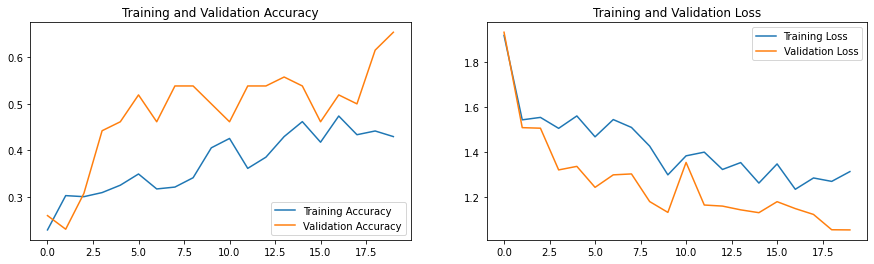

In [40]:
plot_history(history)


**Conclusion:** Reducing the batch size has reduced overfitting

## MODEL 4
> Changing the optmizer from SGD to Adam



In [41]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 8
num_epochs=20



In [42]:
#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 50, 50, 16)    1312      
                                                                 
 batch_normalization_12 (Bat  (None, 15, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 15, 50, 50, 16)    0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 25, 25, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 25, 25, 32)     13856     
                                                                 
 batch_normalization_13 (Bat  (None, 7, 25, 25, 32)   

In [43]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [44]:
model_name = 'model_4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.0840 - categorical_accuracy: 0.2097Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.56475, saving model to model_42023-02-1221_04_11.087627/model-00001-2.08400-0.20965-1.56475-0.32000.h5
83/83 [==============================] - 139s 2s/step - loss: 2.0840 - categorical_accuracy: 0.2097 - val_loss: 1.5647 - val_categorical_accuracy: 0.3200 - lr: 2.0000e-04
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.6001 - categorical_accuracy: 0.2410
Epoch 2: val_loss improved from 1.56475 to 1.47737, saving model to model_42023-02-1221_04_11.087627/model-00002-1.60013-0.24096-1.47737-0.36538.h5
83/83 [==============================] - 117s 1s/step - loss: 1.6001 - categorical_accuracy

**Training Accuracy:** 33.33%

**Validation Accuracy:** 51.92%

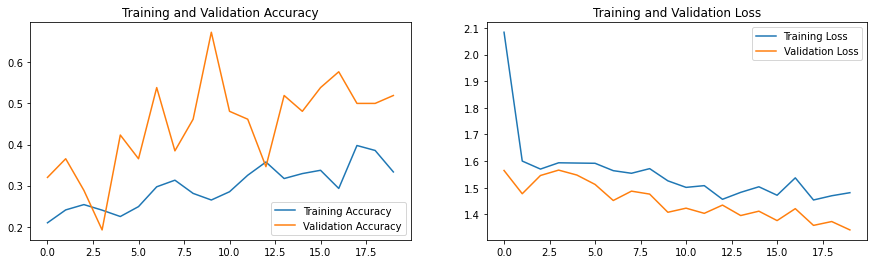

In [47]:
plot_history(history)


> **Conclusion:** Adam has reduced overfitting. However since the accuracy has suddenly depriciated we might need to increase the number of epochs in a later experiment.

## MODEL 5
> Reducing the number of frames from 15 to 10



In [48]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 8
num_epochs=20

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [49]:
#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 10, 50, 50, 16)    1312      
                                                                 
 batch_normalization_15 (Bat  (None, 10, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 10, 50, 50, 16)    0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 5, 25, 25, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 5, 25, 25, 32)     13856     
                                                                 
 batch_normalization_16 (Bat  (None, 5, 25, 25, 32)   

In [50]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [51]:
model_name = 'model_5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [ checkpoint, LR]

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [53]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 1.9669 - categorical_accuracy: 0.2202Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.61631, saving model to model_52023-02-1221_04_11.087627/model-00001-1.96691-0.22021-1.61631-0.21000.h5
83/83 [==============================] - 84s 1s/step - loss: 1.9669 - categorical_accuracy: 0.2202 - val_loss: 1.6163 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.5511 - categorical_accuracy: 0.2995
Epoch 2: val_loss improved from 1.61631 to 1.49262, saving model to model_52023-02-1221_04_11.087627/model-00002-1.55113-0.29948-1.49262-0.38462.h5
83/83 [==============================] - 65s 790ms/step - loss: 1.5511 - categorical_accurac

**Training Accuracy:** 45.379999999999995%

**Validation Accuracy:** 55.769999999999996%

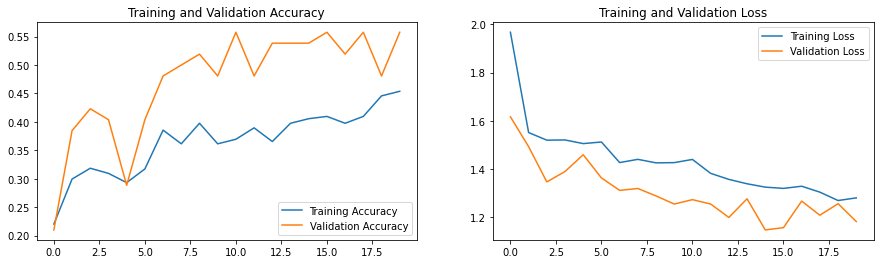

In [54]:
plot_history(history)


> **Conclusion:** The training and validation accuracy has increased after reducing the number of frames from 15 to 10.

## MODEL 6
> Reducing the dropout rate from 0.5 to 0.25 and raising epochs to 25



In [55]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 8

num_epochs=25

In [56]:
#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 10, 50, 50, 16)    1312      
                                                                 
 batch_normalization_18 (Bat  (None, 10, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 10, 50, 50, 16)    0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 5, 25, 25, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 25, 25, 32)     13856     
                                                                 
 batch_normalization_19 (Bat  (None, 5, 25, 25, 32)   

In [57]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [58]:
model_name = 'model_6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [60]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.7425 - categorical_accuracy: 0.2805Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 8

Epoch 1: val_loss improved from inf to 1.72851, saving model to model_62023-02-1221_04_11.087627/model-00001-1.74252-0.28054-1.72851-0.22000.h5
83/83 [==============================] - 107s 1s/step - loss: 1.7425 - categorical_accuracy: 0.2805 - val_loss: 1.7285 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.3880 - categorical_accuracy: 0.3666
Epoch 2: val_loss improved from 1.72851 to 1.54404, saving model to model_62023-02-1221_04_11.087627/model-00002-1.38797-0.36661-1.54404-0.25000.h5
83/83 [==============================] - 87s 1s/step - loss: 1.3880 - categorical_accuracy:

Epoch 22/25
83/83 [==============================] - ETA: 0s - loss: 0.8877 - categorical_accuracy: 0.6185
Epoch 22: val_loss did not improve from 0.75867
83/83 [==============================] - 33s 396ms/step - loss: 0.8877 - categorical_accuracy: 0.6185 - val_loss: 0.8242 - val_categorical_accuracy: 0.6731 - lr: 6.2500e-06
Epoch 23/25
83/83 [==============================] - ETA: 0s - loss: 0.8345 - categorical_accuracy: 0.7189
Epoch 23: val_loss did not improve from 0.75867

Epoch 23: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
83/83 [==============================] - 38s 465ms/step - loss: 0.8345 - categorical_accuracy: 0.7189 - val_loss: 0.8000 - val_categorical_accuracy: 0.7500 - lr: 6.2500e-06
Epoch 24/25
83/83 [==============================] - ETA: 0s - loss: 0.7817 - categorical_accuracy: 0.7189
Epoch 24: val_loss did not improve from 0.75867
83/83 [==============================] - 34s 411ms/step - loss: 0.7817 - categorical_accuracy: 0.7189 - val_loss

**Training Accuracy:** 70.28%

**Validation Accuracy:** 57.69%

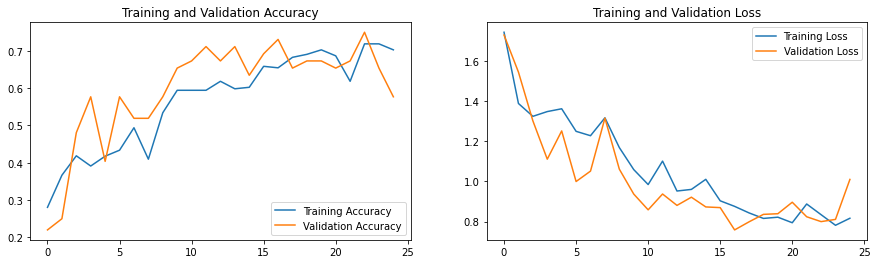

In [61]:
plot_history(history)


> **Conclusion:** A drop out rate of 0.25 gives up a better training and validation accuracy and has significantly reduced overfitting.

## MODEL 7
> Increasing the number of epochs from 25 to 30 and reducing batch_size to 4



In [62]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=30

In [63]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_21 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_22 (Bat  (None, 5, 25, 25, 16)   

In [64]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [65]:
model_name = 'model_7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [66]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [67]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 4
Epoch 1/30
166/166 [==============================] - ETA: 0s - loss: 1.7060 - categorical_accuracy: 0.2443Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.53222, saving model to model_82023-02-1221_04_11.087627/model-00001-1.70600-0.24434-1.53222-0.29000.h5
166/166 [==============================] - 92s 555ms/step - loss: 1.7060 - categorical_accuracy: 0.2443 - val_loss: 1.5322 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04
Epoch 2/30
166/166 [==============================] - ETA: 0s - loss: 1.5651 - categorical_accuracy: 0.2751
Epoch 2: val_loss improved from 1.53222 to 1.41896, saving model to model_82023-02-1221_04_11.087627/model-00002-1.56513-0.27510-1.41896-0.37000.h5
166/166 [==============================] - 71s 431ms/step - loss: 1.5651 - categori

166/166 [==============================] - ETA: 0s - loss: 0.6316 - categorical_accuracy: 0.7490
Epoch 21: val_loss improved from 0.69366 to 0.64072, saving model to model_82023-02-1221_04_11.087627/model-00021-0.63163-0.74900-0.64072-0.77000.h5
166/166 [==============================] - 63s 381ms/step - loss: 0.6316 - categorical_accuracy: 0.7490 - val_loss: 0.6407 - val_categorical_accuracy: 0.7700 - lr: 2.5000e-05
Epoch 22/30
166/166 [==============================] - ETA: 0s - loss: 0.5963 - categorical_accuracy: 0.7771
Epoch 22: val_loss did not improve from 0.64072
166/166 [==============================] - 66s 402ms/step - loss: 0.5963 - categorical_accuracy: 0.7771 - val_loss: 0.7618 - val_categorical_accuracy: 0.7100 - lr: 2.5000e-05
Epoch 23/30
166/166 [==============================] - ETA: 0s - loss: 0.5900 - categorical_accuracy: 0.7811
Epoch 23: val_loss did not improve from 0.64072

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
166/166 [===

**Training Accuracy:** 80.72%

**Validation Accuracy:** 74.0%

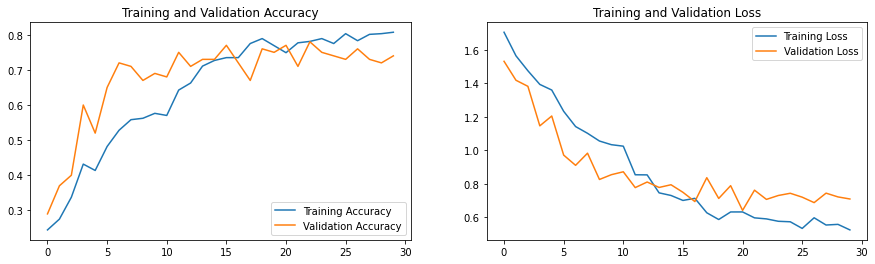

In [68]:
plot_history(history)


## MODEL 8 (LSTM MODEL)
> Trying LSTM configuration to see if the model performance improves

In [74]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'), input_shape=(len(img_idx), image_height, image_width, 3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(64, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(128, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 48, 48, 16)   448       
 tributed)                                                       
                                                                 
 batch_normalization_28 (Bat  (None, 10, 48, 48, 16)   64        
 chNormalization)                                                
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 46, 46, 32)   4640      
 tributed)                                                       
                                                                 
 batch_normalization_29 (Bat  (None, 10, 46, 46, 32)   128       
 chNormalization)                                                
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 44, 44, 64)       

In [75]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [76]:
model_name = 'model_8_LSTM_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [77]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [78]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 4
Epoch 1/30
166/166 [==============================] - ETA: 0s - loss: 1.4399 - categorical_accuracy: 0.3575Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.39230, saving model to model_8LSTM_2023-02-1221_04_11.087627/model-00001-1.43993-0.35747-1.39230-0.38000.h5
166/166 [==============================] - 835s 5s/step - loss: 1.4399 - categorical_accuracy: 0.3575 - val_loss: 1.3923 - val_categorical_accuracy: 0.3800 - lr: 2.0000e-04
Epoch 2/30
166/166 [==============================] - ETA: 0s - loss: 1.3309 - categorical_accuracy: 0.4357
Epoch 2: val_loss improved from 1.39230 to 1.21499, saving model to model_8LSTM_2023-02-1221_04_11.087627/model-00002-1.33086-0.43574-1.21499-0.50000.h5
166/166 [==============================] - 491s 3s/step - loss: 1.3309 - ca

Epoch 21/30
166/166 [==============================] - ETA: 0s - loss: 0.7387 - categorical_accuracy: 0.7149
Epoch 21: val_loss improved from 0.46118 to 0.41740, saving model to model_8LSTM_2023-02-1221_04_11.087627/model-00021-0.73873-0.71486-0.41740-0.84000.h5
166/166 [==============================] - 456s 3s/step - loss: 0.7387 - categorical_accuracy: 0.7149 - val_loss: 0.4174 - val_categorical_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 22/30
166/166 [==============================] - ETA: 0s - loss: 0.7598 - categorical_accuracy: 0.6727
Epoch 22: val_loss did not improve from 0.41740
166/166 [==============================] - 460s 3s/step - loss: 0.7598 - categorical_accuracy: 0.6727 - val_loss: 0.4887 - val_categorical_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 23/30
166/166 [==============================] - ETA: 0s - loss: 0.7072 - categorical_accuracy: 0.7289
Epoch 23: val_loss did not improve from 0.41740

Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

**Training Accuracy:** 78.31%

**Validation Accuracy:** 88.0%

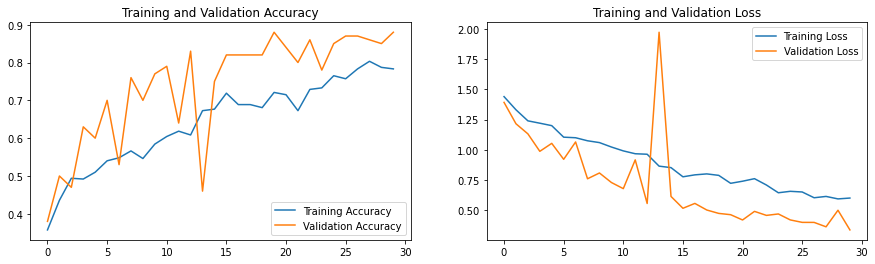

In [79]:
plot_history(history)


### The LSTM model looks quite promising, but despite having good grades, this model took 3+ hours to fully fit. Thus, it is in our best interest to drop such a model.
## We will build a final, more promising MODEL using earlier parameters with slight variations. 

In [80]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=50

In [81]:
#write your model here
model = Sequential()

model.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 10, 50, 50, 16)    1312      
                                                                 
 batch_normalization_32 (Bat  (None, 10, 50, 50, 16)   64        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 10, 50, 50, 16)    0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 5, 25, 25, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 5, 25, 25, 32)     13856     
                                                                 
 batch_normalization_33 (Bat  (None, 5, 25, 25, 32)  

In [82]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [83]:
model_name = 'model_9_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [84]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [85]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/train ; batch size = 4
Epoch 1/50
166/166 [==============================] - ETA: 0s - loss: 1.7411 - categorical_accuracy: 0.2745Source path =  /Users/iraiva/Desktop/DEEP LEARNING/Artificial Neural Networks/rnn/Project_data/val ; batch size = 4

Epoch 1: val_loss improved from inf to 1.46161, saving model to model_92023-02-1221_04_11.087627/model-00001-1.74110-0.27451-1.46161-0.31000.h5
166/166 [==============================] - 79s 477ms/step - loss: 1.7411 - categorical_accuracy: 0.2745 - val_loss: 1.4616 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04
Epoch 2/50
166/166 [==============================] - ETA: 0s - loss: 1.5682 - categorical_accuracy: 0.2871
Epoch 2: val_loss improved from 1.46161 to 1.39772, saving model to model_92023-02-1221_04_11.087627/model-00002-1.56823-0.28715-1.39772-0.39000.h5
166/166 [==============================] - 659s 4s/step - loss: 1.5682 - categorica

166/166 [==============================] - ETA: 0s - loss: 0.4163 - categorical_accuracy: 0.8454
Epoch 21: val_loss improved from 0.64727 to 0.64205, saving model to model_92023-02-1221_04_11.087627/model-00021-0.41627-0.84538-0.64205-0.73000.h5
166/166 [==============================] - 73s 443ms/step - loss: 0.4163 - categorical_accuracy: 0.8454 - val_loss: 0.6421 - val_categorical_accuracy: 0.7300 - lr: 2.5000e-05
Epoch 22/50
166/166 [==============================] - ETA: 0s - loss: 0.3812 - categorical_accuracy: 0.8835
Epoch 22: val_loss did not improve from 0.64205
166/166 [==============================] - 63s 380ms/step - loss: 0.3812 - categorical_accuracy: 0.8835 - val_loss: 0.6654 - val_categorical_accuracy: 0.7100 - lr: 2.5000e-05
Epoch 23/50
166/166 [==============================] - ETA: 0s - loss: 0.3960 - categorical_accuracy: 0.8594
Epoch 23: val_loss did not improve from 0.64205

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
166/166 [===

Epoch 43/50
166/166 [==============================] - ETA: 0s - loss: 0.3360 - categorical_accuracy: 0.8916
Epoch 43: val_loss did not improve from 0.58481
166/166 [==============================] - 68s 410ms/step - loss: 0.3360 - categorical_accuracy: 0.8916 - val_loss: 0.5941 - val_categorical_accuracy: 0.7300 - lr: 4.8828e-08
Epoch 44/50
166/166 [==============================] - ETA: 0s - loss: 0.3363 - categorical_accuracy: 0.8835
Epoch 44: val_loss did not improve from 0.58481

Epoch 44: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
166/166 [==============================] - 85s 517ms/step - loss: 0.3363 - categorical_accuracy: 0.8835 - val_loss: 0.6192 - val_categorical_accuracy: 0.7500 - lr: 4.8828e-08
Epoch 45/50
166/166 [==============================] - ETA: 0s - loss: 0.3001 - categorical_accuracy: 0.9076
Epoch 45: val_loss did not improve from 0.58481
166/166 [==============================] - 67s 407ms/step - loss: 0.3001 - categorical_accuracy: 0.9

**Training Accuracy:** 89.36%

**Validation Accuracy:** 74.0%

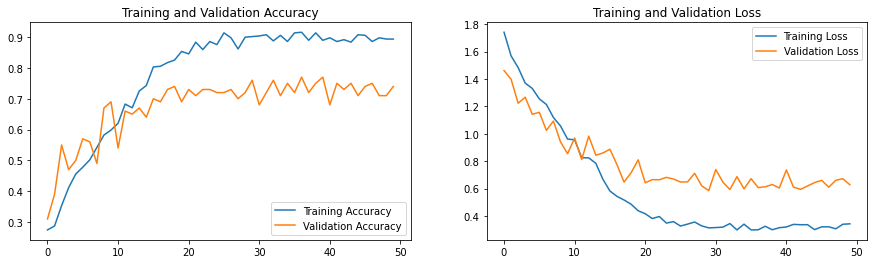

In [86]:
plot_historyhistory(history)